In [1]:
using Phylo, Plots, FASTX, MolecularEvolution, CodonMolecularEvolution, JLD2, MCMCChains, StatsPlots, MCMCDiagnosticTools

In [8]:
include("../src/difFUBAR/skbDifFUBAR.jl")

skbdifFUBAR (generic function with 1 method)

In [25]:
@load "../output/alloc_grid.jld2" alloc_grid
@load "../output/ambient_samples.jld2" ambient_samples
@load "../output/model.jld2" model_dict 


1-element Vector{Symbol}:
 :model_dict

In [27]:
square_distance_matrix = generate_square_l2_distance_matrix(model_dict[:codon_param_index_vec])
kernel_stddev = 1.0 # example values idk what these should be xD
suppression_stddev = 1.0
model = SKBDIModel(
    model_dict[:parameter_grids],
    model_dict[:parameter_names],
    model_dict[:hypothesis_masks],
    s -> CodonMolecularEvolution.quintic_smooth_transition(-1, 1, s),
    model_dict[:log_con_lik_matrix],
    model_dict[:con_lik_matrix],
    model_dict[:codon_param_vec],
    model_dict[:codon_param_index_vec],
    s -> hedwigs_ambient_to_parameter_transform(
                s,
                model_dict[:kernel_dim],
                model_dict[:suppression_dim],
                kernel_stddev,
                suppression_stddev,
                square_distance_matrix,
                fast_cov_mat_hedwigs_kernel),
    1)

SKBDIModel([[0.009999999999999995, 0.20099800796022266, 1.0, 4.342465139303896], [0.009999999999999995, 0.20099800796022266, 1.0, 4.342465139303896], [0.05, 0.274037034920393, 1.0, 3.3523888666641257]], ["alpha", "omega_1", "omega_2", "background_omega"], Bool[0 0 … 1 1; 0 0 … 1 1; 0 0 … 0 0; 0 0 … 0 0], var"#59#61"(), [-3.840116596383576 -27.126453480219148 … -47.94676925041362 -21.72547919316213; -3.8455403878132084 -23.72670233188231 … -47.95002342516052 -20.027944593930258; … ; -49.41159976607465 -47.18207122356033 … -57.75374735572603 -47.48685448307529; -58.975426354939906 -51.86647355650242 … -64.89056200531437 -55.52776919935319], [1.0 1.8059820321038598e-6 … 6.219050670345792e-11 8.198640194770358e-5; 0.9945908907707129 5.410116145445005e-5 … 6.198845685810149e-11 0.0004476841685297935; … ; 1.6164278604582168e-20 3.5210266166650205e-15 … 3.424582397078514e-15 5.317637063210701e-16; 1.135113304042042e-24 3.2528139503243396e-17 … 2.723506394710052e-18 1.7123549833933696e-19], [[

In [28]:
ambient_sample_mat = reduce(hcat, ambient_samples)
#ambient_sample_mat[output_grid.kernel_dim + 1:model_dict[:kernel_dim + model_dict[:suppression_dim, :]
ambient_sample_mat = permutedims(ambient_sample_mat, (2, 1))        # 3D: iterations × parameters × chains
print(size(ambient_sample_mat))
ambient_sample_mat = reshape(ambient_sample_mat, size(ambient_sample_mat)..., 1)
#=param_names = [:θ1, :θ2, :θ3, :θ4]
chain = Chains(vals, param_names) =#
println(model_dict[:kernel_dim])
println(model_dict[:suppression_dim])

(100, 261)1
4


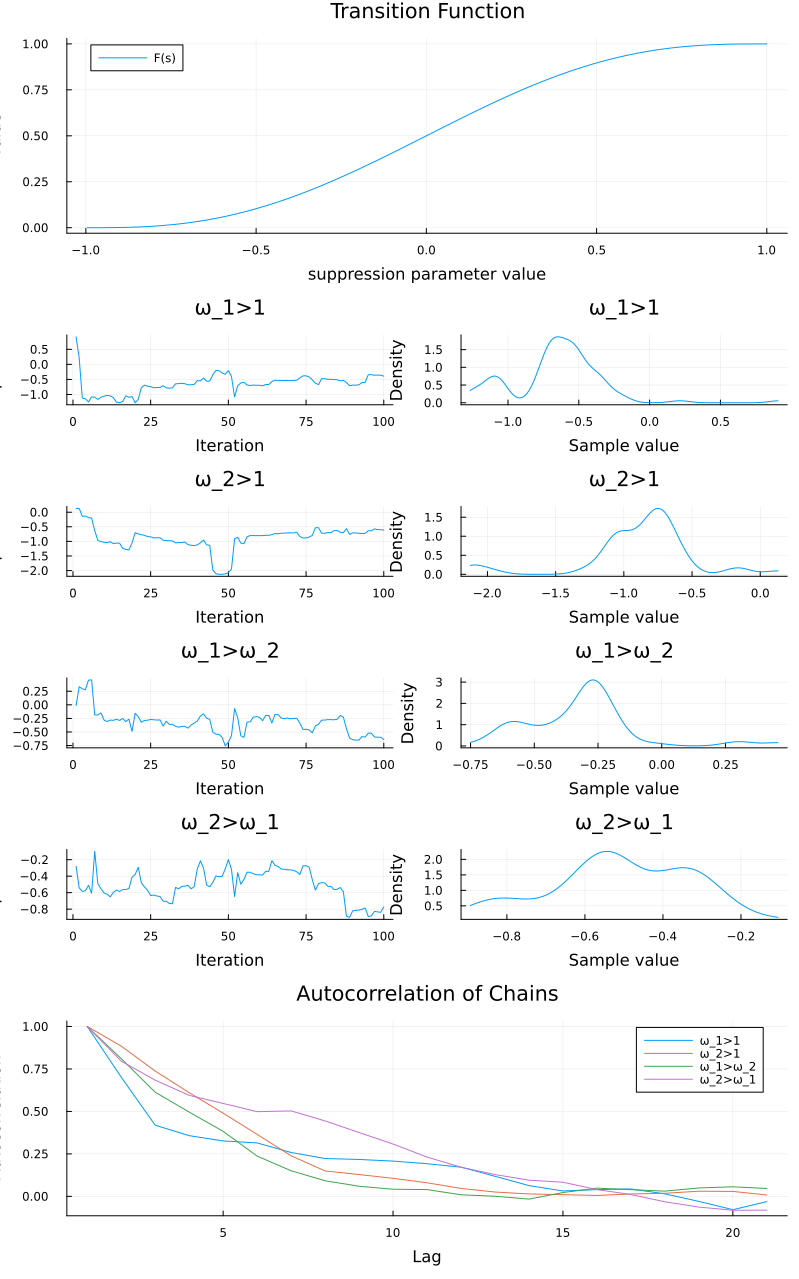

In [29]:
F = s -> CodonMolecularEvolution.quintic_smooth_transition(s, -1, 1)
s_values = -1 .+ 2/ 500 .* (1:500) 
F_values = F.(s_values)
hypothesis_names = ["ω_1>1", "ω_2>1", "ω_1>ω_2", "ω_2>ω_1"]
F = s -> CodonMolecularEvolution.quintic_smooth_transition(s, -1, 1)
p1 = plot(s_values, F_values, label="F(s)", title="Transition Function", xlabel="suppression parameter value", ylabel="Value")
chn = Chains(ambient_sample_mat[:, model_dict[:kernel_dim] + 1:model_dict[:kernel_dim] + model_dict[:suppression_dim], :], hypothesis_names)
p2 = plot(chn)
p3 = plot(autocor(chn[hypothesis_names[1]]), label=hypothesis_names[1], title="Autocorrelation of Chains", xlabel="Lag", ylabel="Autocorrelation")
for i in 2:length(hypothesis_names)
    plot!(autocor(chn[hypothesis_names[i]]), label=hypothesis_names[i])
end
plot(p1, p2, p3, layout = @layout([a{0.2h}; b; c{0.2h}]), size =(800, 1.6 * 800))


In [30]:
for i = 1:model_dict[:suppression_dim]
    println("P(F(s) > 0) for hypothesis ", hypothesis_names[i], ") = ", mean([F(a[model_dict[:kernel_dim] + i]) > 0 for a in ambient_samples]))
end

P(F(s) > 0) for hypothesis ω_1>1) = 0.8
P(F(s) > 0) for hypothesis ω_2>1) = 0.69
P(F(s) > 0) for hypothesis ω_1>ω_2) = 1.0
P(F(s) > 0) for hypothesis ω_2>ω_1) = 1.0


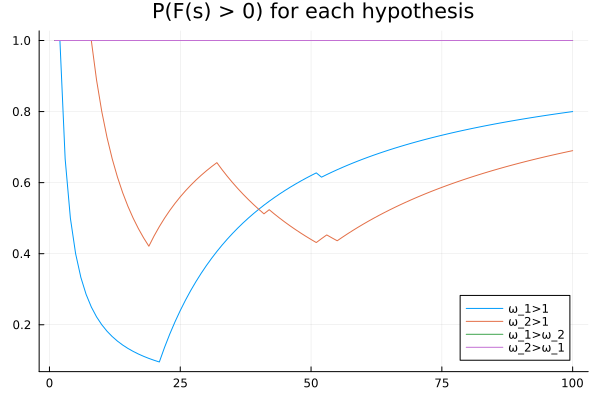

In [31]:
f = (i, j) -> mean([F(ambient_samples[k][model_dict[:kernel_dim] + i]) > 0 for k in 1:j])
p1 = plot(1:100, f.(1, 1:100), label=hypothesis_names[1], title="P(F(s) > 0) for each hypothesis")
for i in 2:model_dict[:suppression_dim]
    plot!(1:100, f.(i, 1:100), label=hypothesis_names[i])
end
display(p1)

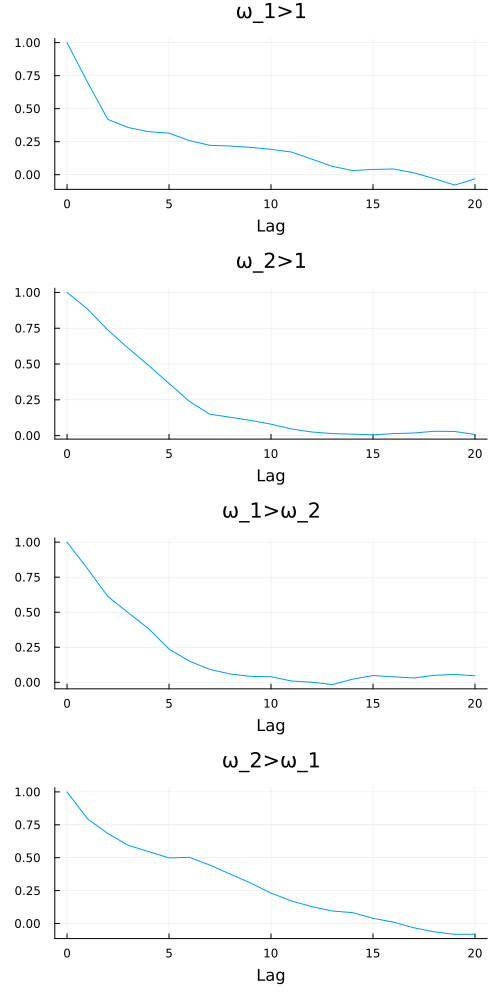

In [32]:
autocorplot(chn)

In [33]:
ess(chn)

ESS
  parameters       ess   ess_per_sec 
      Symbol   Float64       Missing 

       ω_1>1    6.2738       missing
       ω_2>1    3.9108       missing
     ω_1>ω_2   13.9357       missing
     ω_2>ω_1   10.7654       missing


In [ ]:
# Plot log-likelihoods

LL = [log_likelihood(model, sample) for sample in ambient_samples]
println(typeof(LL))
p4 = plot(1:length(LL), LL, label="Log-Likelihoods", title="Log-Likelihoods over iterations", xlabel="Iteration", ylabel="Log-Likelihood")
display(p4)

MethodError: MethodError: no method matching hedwigs_ambient_to_parameter_transform(::Vector{Float64}, ::Int64, ::Int64, ::Float64, ::Float64, ::Matrix{Int64}, ::typeof(fast_cov_mat_hedwigs_kernel))
The function `hedwigs_ambient_to_parameter_transform` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  hedwigs_ambient_to_parameter_transform(!Matched::SKBDIModel, !Matched::Vector{Float64}, !Matched::Float64, ::Float64, !Matched::Matrix{Int64}, !Matched::Function, !Matched::Float64)
   @ Main c:\Users\toven\Documents\tove-code\CodonMolecularEvolution.jl-1\src\difFUBAR\skbDifFUBAR.jl:174
  hedwigs_ambient_to_parameter_transform(!Matched::SKBDIModel, !Matched::Vector{Float64}, !Matched::Float64, ::Float64, !Matched::Matrix{Int64}, !Matched::Function)
   @ Main c:\Users\toven\Documents\tove-code\CodonMolecularEvolution.jl-1\src\difFUBAR\skbDifFUBAR.jl:174
